# Convert and Optimize YOLOv8 real-time object detection with OpenVINO™

Real-time object detection is often used as a key component in computer vision systems.
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLOv8 with OpenVINO. We consider the steps required for object detection scenario.

The tutorial consists of the following steps:
- Prepare the PyTorch model.
- Download and prepare a dataset.
- Validate the original model.
- Convert the PyTorch model to OpenVINO IR.
- Validate the converted model.
- Prepare and run optimization pipeline.
- Compare performance of the FP32 and quantized models.
- Compare accuracy of the FP32 and quantized models.
- Other optimization possibilities with OpenVINO api
- Live demo



#### Table of contents:

- [Get PyTorch model](#Get-PyTorch-model)
    - [Prerequisites](#Prerequisites)
- [Instantiate model](#Instantiate-model)
    - [Convert model to OpenVINO IR](#Convert-model-to-OpenVINO-IR)
    - [Verify model inference](#Verify-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Test on single image](#Test-on-single-image)
- [Check model accuracy on the dataset](#Check-model-accuracy-on-the-dataset)
    - [Download the validation dataset](#Download-the-validation-dataset)
    - [Define validation function](#Define-validation-function)
    - [Configure Validator helper and create DataLoader](#Configure-Validator-helper-and-create-DataLoader)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Validate Quantized model inference](#Validate-Quantized-model-inference)
- [Compare the Original and Quantized Models](#Compare-the-Original-and-Quantized-Models)
    - [Compare performance object detection models](#Compare-performance-object-detection-models)
    - [Validate quantized model accuracy](#Validate-quantized-model-accuracy)
- [Next steps](#Next-steps)
    - [Async inference pipeline](#Async-inference-pipeline)
    - [Integration preprocessing to model](#Integration-preprocessing-to-model)
        - [Initialize PrePostProcessing API](#Initialize-PrePostProcessing-API)
        - [Define input data format](#Define-input-data-format)
        - [Describe preprocessing steps](#Describe-preprocessing-steps)
        - [Integrating Steps into a Model](#Integrating-Steps-into-a-Model)
        - [Postprocessing](#Postprocessing)
- [Live demo](#Live-demo)
    - [Run Live Object Detection](#Run-Live-Object-Detection)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/yolov8-optimization/yolov8-object-detection.ipynb" />


## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, the creators of the model provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR. Therefore, we do not need to do these steps manually.

#### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [19]:
%pip install -q "openvino>=2024.0.0" "nncf>=2.9.0"
%pip install -q "torch>=2.1" "torchvision>=0.16" "ultralytics==8.2.24" onnx tqdm opencv-python --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [20]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer, device_widget, quantization_widget

In [21]:
# Download a test sample
IMAGE_PATH = Path("./data/construction.jpg")


## Instantiate model
[back to top ⬆️](#Table-of-contents:)

There are [several models](https://docs.ultralytics.com/tasks/detect/) available in the original repository, targeted for different tasks. For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically). 

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes for object detection model. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:

In [22]:
models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

In [27]:
from PIL import Image
from ultralytics import YOLO
from pathlib import Path

# Model and image setup
DET_MODEL_NAME = "yolov8n"
models_dir = Path("./models")  # Ensure this is where your models are saved
IMAGE_PATH = Path("./data/construction_1.jpg")  # Replace with your image path

# Check if the model file exists
model_path = models_dir / f"{DET_MODEL_NAME}.pt"
if not model_path.exists():
    print(f"Model file not found at {model_path}")
else:
    print(f"Model file found at {model_path}")

# Check if the image file exists
if not IMAGE_PATH.exists():
    print(f"Image file not found at {IMAGE_PATH}")
else:
    print(f"Image file found at {IMAGE_PATH}")

    # Load the YOLO model
    det_model = YOLO(model_path)

    # Run the detection
    res = det_model(IMAGE_PATH)

    # Get the resulting image with bounding boxes drawn
    result_img = Image.fromarray(res[0].plot()[:, :, ::-1])

    # Display the result
    result_img.show()  # This will open the image with detections in your default image viewer


Model file found at models\yolov8n.pt
Image file found at data\construction_1.jpg

image 1/1 c:\Users\Preethi.R\Desktop\sitesafeai\data\construction_1.jpg: 640x640 9 persons, 396.7ms
Speed: 12.6ms preprocess, 396.7ms inference, 3015.0ms postprocess per image at shape (1, 3, 640, 640)


### Convert model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [32]:
from ultralytics import YOLO

# Load pre-trained YOLO model (you can use YOLOv8n, YOLOv8s, etc.)
model = YOLO('yolov8n.pt')  # Pre-trained model from Ultralytics

# Define the path to your dataset's `data.yaml` file
data_yaml_path = './data.yaml'  # Path to your custom dataset's data.yaml

# Train the model on your custom dataset
model.train(data=data_yaml_path, epochs=30, imgsz=640, batch=16)

# After training, the model will be saved in a directory, typically:
# `runs/train/exp/weights/best.pt`


New https://pypi.org/project/ultralytics/8.3.39 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.24  Python-3.11.4 torch-2.1.0+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fal

train: Scanning C:\Users\Preethi.R\Desktop\sitesafeai\datasets\test\labels.cache... 82 images, 8 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]
val: Scanning C:\Users\Preethi.R\Desktop\sitesafeai\datasets\valid\labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.442      4.024      1.485         39        640: 100%|██████████| 6/6 [01:42<00:00, 17.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:14<00:00, 18.66s/it]

                   all        114        697    0.00867       0.25     0.0397     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.571      3.988      1.502         21        640: 100%|██████████| 6/6 [01:40<00:00, 16.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:01<00:00, 15.33s/it]

                   all        114        697      0.017      0.253     0.0661      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.434       3.69      1.472         21        640: 100%|██████████| 6/6 [01:24<00:00, 14.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:58<00:00, 14.61s/it]

                   all        114        697     0.0174      0.267     0.0775     0.0497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.369      3.469      1.378         24        640: 100%|██████████| 6/6 [01:25<00:00, 14.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:45<00:00, 26.37s/it]

                   all        114        697     0.0171      0.279     0.0801     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.486      3.205      1.446         57        640: 100%|██████████| 6/6 [02:15<00:00, 22.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:19<00:00, 34.97s/it]

                   all        114        697     0.0151      0.266     0.0819     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.279      2.911      1.358         17        640: 100%|██████████| 6/6 [01:50<00:00, 18.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:16<00:00, 19.10s/it]

                   all        114        697     0.0133      0.305     0.0838     0.0555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.475      2.687      1.408         33        640: 100%|██████████| 6/6 [01:46<00:00, 17.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:55<00:00, 28.91s/it]

                   all        114        697      0.941     0.0456      0.138     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.425      2.535      1.399         40        640: 100%|██████████| 6/6 [02:17<00:00, 22.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:57<00:00, 29.25s/it]

                   all        114        697      0.943     0.0338      0.184      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.386      2.322      1.398         27        640: 100%|██████████| 6/6 [02:51<00:00, 28.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:06<00:00, 31.72s/it]

                   all        114        697      0.907     0.0712      0.231      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G        1.4      2.156      1.348         46        640: 100%|██████████| 6/6 [03:03<00:00, 30.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:07<00:00, 31.93s/it]

                   all        114        697      0.852      0.115      0.251      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.425      2.182      1.366         42        640: 100%|██████████| 6/6 [03:30<00:00, 35.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:30<00:00, 37.61s/it]

                   all        114        697      0.796      0.146      0.259      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.377      2.076      1.447         22        640: 100%|██████████| 6/6 [03:53<00:00, 38.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:36<00:00, 39.02s/it]

                   all        114        697      0.705      0.171      0.284      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.365      1.985       1.35         20        640: 100%|██████████| 6/6 [02:47<00:00, 27.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:07<00:00, 16.85s/it]

                   all        114        697      0.661      0.198      0.288      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G       1.42      1.917      1.318         41        640: 100%|██████████| 6/6 [01:45<00:00, 17.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:13<00:00, 18.43s/it]

                   all        114        697      0.648      0.221      0.302      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.313      2.034      1.348         17        640: 100%|██████████| 6/6 [01:42<00:00, 17.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:12<00:00, 18.18s/it]

                   all        114        697      0.647       0.22      0.312      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.381       1.96      1.303         31        640: 100%|██████████| 6/6 [01:45<00:00, 17.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:23<00:00, 20.81s/it]

                   all        114        697      0.604      0.231      0.316      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.258      1.911      1.331          8        640: 100%|██████████| 6/6 [02:15<00:00, 22.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:25<00:00, 21.39s/it]

                   all        114        697      0.584      0.242      0.312      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.262      1.715      1.297         12        640: 100%|██████████| 6/6 [01:43<00:00, 17.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:36<00:00, 24.21s/it]

                   all        114        697       0.46      0.292      0.327       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.403      1.849      1.413         15        640: 100%|██████████| 6/6 [02:46<00:00, 27.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:51<00:00, 27.90s/it]

                   all        114        697      0.457       0.32      0.336      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.225      1.632      1.303         20        640: 100%|██████████| 6/6 [04:21<00:00, 43.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [1:20:42<00:00, 1210.69s/it]  

                   all        114        697      0.548      0.356      0.374      0.195


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.235      1.973      1.245         11        640: 100%|██████████| 6/6 [27:01<00:00, 270.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:10<00:00, 17.72s/it]

                   all        114        697       0.54      0.352      0.379      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.159       1.66      1.238          6        640: 100%|██████████| 6/6 [02:14<00:00, 22.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:16<00:00, 34.05s/it]

                   all        114        697      0.547       0.36      0.369      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G        1.3      1.872      1.269         15        640: 100%|██████████| 6/6 [04:24<00:00, 44.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:32<00:00, 38.14s/it]

                   all        114        697      0.537      0.338      0.364        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.227      1.841      1.279         18        640: 100%|██████████| 6/6 [01:47<00:00, 18.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:13<00:00, 18.48s/it]

                   all        114        697      0.527      0.343      0.372      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G       1.21      1.676      1.258         39        640: 100%|██████████| 6/6 [01:44<00:00, 17.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:12<00:00, 18.03s/it]

                   all        114        697      0.521       0.35      0.374      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.234      1.855      1.329         14        640: 100%|██████████| 6/6 [01:43<00:00, 17.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:13<00:00, 18.30s/it]

                   all        114        697      0.509      0.386      0.393      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.243      1.713      1.225         31        640: 100%|██████████| 6/6 [01:45<00:00, 17.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:12<00:00, 18.18s/it]

                   all        114        697      0.506      0.388      0.403      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.307      2.057      1.334          4        640: 100%|██████████| 6/6 [01:45<00:00, 17.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:12<00:00, 18.05s/it]

                   all        114        697      0.563      0.387      0.426      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G       1.41      1.839      1.436          8        640: 100%|██████████| 6/6 [01:44<00:00, 17.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:22<00:00, 20.74s/it]

                   all        114        697      0.589       0.38       0.43      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.081      1.502      1.223          8        640: 100%|██████████| 6/6 [01:52<00:00, 18.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:24<00:00, 21.02s/it]

                   all        114        697      0.599      0.383      0.435      0.253



30 epochs completed in 3.680 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.3MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics YOLOv8.2.24  Python-3.11.4 torch-2.1.0+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:03<00:00, 15.84s/it]


                   all        114        697      0.594      0.382       0.43      0.253
               Hardhat        114         79      0.861      0.506      0.604      0.404
                  Mask        114         21       0.77      0.667      0.707      0.481
            NO-Hardhat        114         69      0.395      0.152      0.182      0.075
               NO-Mask        114         74      0.306      0.131      0.142     0.0397
        NO-Safety Vest        114        106      0.547      0.368      0.402      0.221
                Person        114        166      0.784      0.548      0.621      0.419
           Safety Cone        114         44      0.653      0.318      0.306      0.103
           Safety Vest        114         41      0.575      0.415      0.477      0.252
             machinery        114         55      0.464      0.509      0.569      0.343
               vehicle        114         42      0.589      0.205      0.295      0.189
Speed: 7.8ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000298CBD6C810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [34]:
# After training, export the model to OpenVINO format
trained_model_path = 'runs/detect/train4/weights/best.pt'  # Path to your best trained model
det_model = YOLO(trained_model_path)

# Export the trained model to OpenVINO format
export_path = models_dir / f"{DET_MODEL_NAME}_openvino_model"
det_model.export(format="openvino", dynamic=True, half=True, save_dir=export_path)


Ultralytics YOLOv8.2.24  Python-3.11.4 torch-2.1.0+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\train4\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (6.0 MB)

OpenVINO: starting export with openvino 2024.5.0-17288-7975fa5da0c-refs/pull/3856/head...

OpenVINO: export success  7.2s, saved as 'runs\detect\train4\weights\best_openvino_model\' (6.1 MB)

Export complete (10.1s)
Results saved to C:\Users\Preethi.R\Desktop\sitesafeai\runs\detect\train4\weights
Predict:         yolo predict task=detect model=runs\detect\train4\weights\best_openvino_model imgsz=640 half 
Validate:        yolo val task=detect model=runs\detect\train4\weights\best_openvino_model imgsz=640 data=./data.yaml half 
Visualize:       https://netron.app


'runs\\detect\\train4\\weights\\best_openvino_model'

In [38]:
device = device_widget()

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [50]:
import numpy as np
from PIL import Image, ImageDraw
from openvino.runtime import Core

# Define constants
IMAGE_PATH = "data/construction_1.jpg"  # Path to your input image
MODEL_PATH = "runs/detect/train4/weights/best_openvino_model/best.xml"  # Path to your OpenVINO model
CONFIDENCE_THRESHOLD = 0.5  # Minimum confidence for detections

# Initialize OpenVINO runtime and load the model
core = Core()
det_model = core.read_model(MODEL_PATH)
det_compiled_model = core.compile_model(det_model, "CPU")  # Adjust the device as needed

def draw_boxes(image, detections):
    draw = ImageDraw.Draw(image)
    width, height = image.size  # Get the image dimensions

    for detection in detections:
        # Extract detection information
        x_min, y_min, x_max, y_max = detection[:4]
        conf = detection[4]
        class_id = int(detection[5]) if len(detection) > 5 else -1  # Handle class ID

        # Convert normalized coordinates (if needed) to pixel coordinates
        x_min = int(min(x_min, x_max) * width)
        x_max = int(max(x_min, x_max) * width)
        y_min = int(min(y_min, y_max) * height)
        y_max = int(max(y_min, y_max) * height)

        # Draw only detections above the confidence threshold
        if conf > CONFIDENCE_THRESHOLD:
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            label = f"Class: {class_id if class_id >= 0 else 'N/A'}, Conf: {conf:.2f}"
            draw.text((x_min, max(0, y_min - 10)), label, fill="red")
    return image
# Load and preprocess the input image
input_image = preprocess_image(IMAGE_PATH)

# Perform inference
results = infer_with_openvino(det_compiled_model, input_image)

# Post-process the results
detections = results.squeeze()  # Remove batch dimension
print(f"Detections: {detections}")

# Visualize detections on the original image
original_image = Image.open(IMAGE_PATH)
image_with_boxes = draw_boxes(original_image, detections)
image_with_boxes.show()

   

Detections: [[     6.5423      16.052      21.127 ...      502.52      529.78      536.05]
 [     3.1839        3.35      3.4979 ...      602.38      604.56      607.93]
 [     11.457      23.738      15.037 ...      262.16      219.03      205.86]
 ...
 [    0.01959     0.98277     0.99733 ...  0.00096506   0.0010144  0.00090247]
 [  0.0024092     0.99731      0.8819 ...   0.0012686   0.0015902   0.0011125]
 [    0.99991           1     0.99968 ...   0.0032267   0.0028952    0.001834]]


### Verify model inference
[back to top ⬆️](#Table-of-contents:)

We can reuse the base model pipeline for pre- and postprocessing just replacing the inference method where we will use the IR model for inference.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [25]:
device = device_widget()

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

### Test on single image
[back to top ⬆️](#Table-of-contents:)

Now, once we have defined preprocessing and postprocessing steps, we are ready to check model prediction for object detection.

In [31]:
import numpy as np
from openvino.runtime import Core
from PIL import Image

# Load OpenVINO model
ie = Core()
model_path = "models\yolov8n_openvino_model\yolov8n.xml"  # Your OpenVINO model path
model = ie.read_model(model=model_path)
compiled_model = ie.compile_model(model=model, device_name="AUTO")

# Image path
image_path = "data/construction_1.jpg"
image = Image.open(image_path)

# Preprocess the image
image = image.resize((640, 640))  # Resize to 640x640
image = np.array(image)  # Convert to numpy array
image = image.transpose((2, 0, 1))  # Change to (C, H, W)
image = np.expand_dims(image, axis=0)  # Add batch dimension -> (1, C, H, W)
image = image.astype(np.float32)  # Convert to float32

# Run inference
results = compiled_model([image])

# Post-process the results (e.g., drawing bounding boxes)
result_img = Image.fromarray(results[0].plot()[:, :, ::-1])  # Convert back to RGB format
result_img.show()


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

## Check model accuracy on the dataset
[back to top ⬆️](#Table-of-contents:)

For comparing the optimized model result with the original, it is good to know some measurable results in terms of model accuracy on the validation dataset. 


### Download the validation dataset
[back to top ⬆️](#Table-of-contents:)

YOLOv8 is pre-trained on the COCO dataset, so to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the author of the model, for use with the original model evaluation function.

>**Note**: The initial dataset download may take a few minutes to complete. The download speed will vary depending on the quality of your internet connection.

In [ ]:
from zipfile import ZipFile

from ultralytics.data.utils import DATASETS_DIR


DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco.yaml"

OUT_DIR = DATASETS_DIR

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"

download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(LABELS_PATH, "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(DATA_PATH, "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / "coco/images")

/home/akash/intel/NNCF/nncf/examples/post_training_quantization/openvino/yolov8/datasets/val2017.zip:   0%|   …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

'/home/akash/intel/NNCF/nncf/examples/post_training_quantization/openvino/yolov8/datasets/coco2017labels-segments.zip' already exists.


/home/akash/intel/NNCF/nncf/examples/post_training_quantization/openvino/yolov8/datasets/coco.yaml:   0%|     …

### Define validation function
[back to top ⬆️](#Table-of-contents:)


In [ ]:
import numpy as np

from tqdm.notebook import tqdm
from ultralytics.utils.metrics import ConfusionMatrix


def test(
    model: ov.Model,
    core: ov.Core,
    data_loader: torch.utils.data.DataLoader,
    validator,
    num_samples: int = None,
):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        validator: instance of validator class
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = dict(tp=[], conf=[], pred_cls=[], target_cls=[])
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(tqdm(data_loader, total=num_samples)):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        preds = torch.from_numpy(results[compiled_model.output(0)])
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats: np.ndarray, total_images: int, total_objects: int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes:")
    mp, mr, map50, mean_ap = (
        stats["metrics/precision(B)"],
        stats["metrics/recall(B)"],
        stats["metrics/mAP50(B)"],
        stats["metrics/mAP50-95(B)"],
    )
    # Print results
    print("    Best mean average:")
    s = ("%20s" + "%12s" * 6) % (
        "Class",
        "Images",
        "Labels",
        "Precision",
        "Recall",
        "mAP@.5",
        "mAP@.5:.95",
    )
    print(s)
    pf = "%20s" + "%12i" * 2 + "%12.3g" * 4  # print format
    print(pf % ("all", total_images, total_objects, mp, mr, map50, mean_ap))
    if "metrics/precision(M)" in stats:
        s_mp, s_mr, s_map50, s_mean_ap = (
            stats["metrics/precision(M)"],
            stats["metrics/recall(M)"],
            stats["metrics/mAP50(M)"],
            stats["metrics/mAP50-95(M)"],
        )
        # Print results
        print("    Macro average mean:")
        s = ("%20s" + "%12s" * 6) % (
            "Class",
            "Images",
            "Labels",
            "Precision",
            "Recall",
            "mAP@.5",
            "mAP@.5:.95",
        )
        print(s)
        pf = "%20s" + "%12i" * 2 + "%12.3g" * 4  # print format
        print(pf % ("all", total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))

### Configure Validator helper and create DataLoader
[back to top ⬆️](#Table-of-contents:)

The original model repository uses a `Validator` wrapper, which represents the accuracy validation pipeline. It creates dataloader and evaluation metrics and updates metrics on each data batch produced by the dataloader. Besides that, it is responsible for data preprocessing and results postprocessing. For class initialization, the configuration should be provided. We will use the default setup, but it can be replaced with some parameters overriding to test on custom data. The model has connected the `ValidatorClass` method, which creates a validator class instance.

In [ ]:
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class
from ultralytics.data.utils import check_det_dataset

args = get_cfg(cfg=DEFAULT_CFG)
args.data = str(CFG_PATH)

In [ ]:
det_validator = det_model.task_map[det_model.task]["validator"](args=args)

In [ ]:
det_validator.data = check_det_dataset(args.data)
det_validator.stride = 32
det_data_loader = det_validator.get_dataloader(OUT_DIR / "coco", 1)

val: Scanning /home/akash/intel/NNCF/nncf/examples/post_training_quantization/openvino/yolov8/datasets/coco/labels/val2017.cache... 4952 images,


In [ ]:
det_validator.is_coco = True
det_validator.class_map = coco80_to_coco91_class()
det_validator.names = det_model.model.names
det_validator.metrics.names = det_validator.names
det_validator.nc = det_model.model.model[-1].nc

After definition test function and validator creation, we are ready for getting accuracy metrics
>**Note**: Model evaluation is time consuming process and can take several minutes, depending on the hardware. For reducing calculation time, we define `num_samples` parameter with evaluation subset size, but in this case, accuracy can be noncomparable with originally reported by the authors of the model, due to validation subset difference.
*To validate the models on the full dataset set `NUM_TEST_SAMPLES = None`.*

In [ ]:
NUM_TEST_SAMPLES = 300

In [ ]:
fp_det_stats = test(det_ov_model, core, det_data_loader, det_validator, num_samples=NUM_TEST_SAMPLES)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
print_stats(fp_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2145       0.594       0.542       0.579       0.417


`print_stats` reports the following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve aggregated over all classes in the dataset, where `t` is the Intersection Over Union (IOU) threshold, degree of overlapping between ground truth and predicted objects. Therefore, `mAP@.5` indicates that mean average precision is calculated at 0.5 IOU threshold, `mAP@.5:.95` - is calculated on range IOU thresholds from 0.5 to 0.95 with step 0.05.

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv8.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.runtime.serialize` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [ ]:
int8_model_det_path = models_dir / f"{DET_MODEL_NAME}_openvino_int8_model/{DET_MODEL_NAME}.xml"
quantized_det_model = None

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [ ]:
# Fetch skip_kernel_extension module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define a transformation function for getting only input tensors.

In [ ]:
%%skip not $to_quantize.value

import nncf
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [ ]:
%%skip not $to_quantize.value

ignored_scope = nncf.IgnoredScope( # post-processing
    subgraphs=[
        nncf.Subgraph(inputs=['__module.model.22/aten::cat/Concat',
                              '__module.model.22/aten::cat/Concat_1',
                              '__module.model.22/aten::cat/Concat_2'],
                      outputs=['__module.model.22/aten::cat/Concat_7'])
    ]
)

# Detection model
quantized_det_model = nncf.quantize(
    det_ov_model,
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=ignored_scope
)

INFO:nncf:105 ignored nodes were found by subgraphs in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 126 __module.model.22/aten::cat/Concat
INFO:nncf:Not adding activation input quantizer for operation: 133 __module.model.22/aten::view/Reshape_3
INFO:nncf:Not adding activation input quantizer for operation: 240 __module.model.22/aten::cat/Concat_1
INFO:nncf:Not adding activation input quantizer for operation: 250 __module.model.22/aten::view/Reshape_4
INFO:nncf:Not adding activation input quantizer for operation: 297 __module.model.22/aten::cat/Concat_2
INFO:nncf:Not adding activation input quantizer for operation: 299 __module.model.22/aten::view/Reshape_5
INFO:nncf:Not adding activation input quantizer for operation: 143 __module.model.22/aten::cat/Concat_4
INFO:nncf:Not adding activation input quantizer for operation: 154 __module.model.22/prim::ListUnpack
INFO:nncf:Not adding activation input quantizer for operation: 166 __module.model.22.dfl/aten::vi

Output()

Output()

In [ ]:
%%skip not $to_quantize.value

print(f"Quantized detection model will be saved to {int8_model_det_path}")
ov.save_model(quantized_det_model, str(int8_model_det_path))

Quantized detection model will be saved to models/yolov8n_openvino_int8_model/yolov8n.xml


### Validate Quantized model inference
[back to top ⬆️](#Table-of-contents:)

`nncf.quantize` returns the OpenVINO Model class instance, which is suitable for loading on a device for making predictions. `INT8` model input data and output result formats have no difference from the floating point model representation. Therefore, we can reuse the same `detect` function defined above for getting the `INT8` model result on the image.

In [ ]:
%%skip not $to_quantize.value

device


image 1/1 /home/akash/intel/openvino_notebooks/notebooks/yolov8-optimization/data/coco_bike.jpg: 640x640 2 bicycles, 2 cars, 1 dog, 10.9ms
Speed: 3.7ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


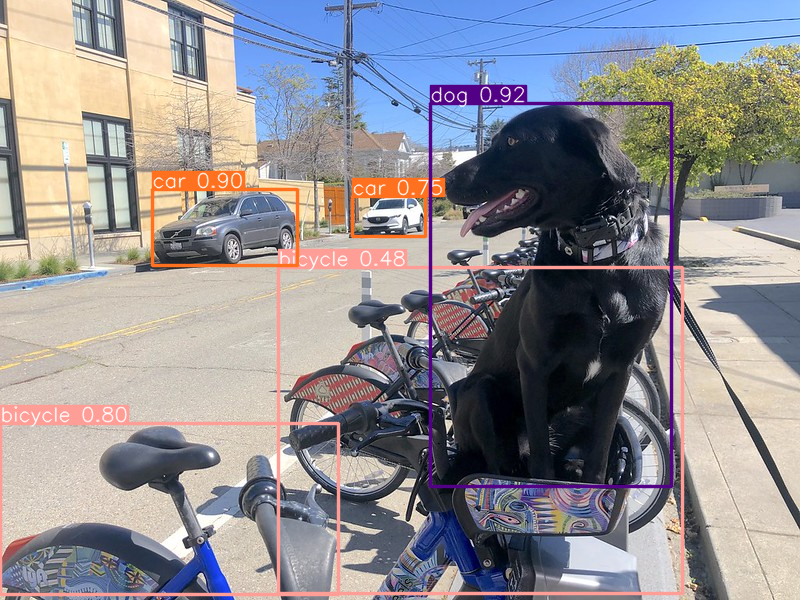

In [ ]:
%%skip not $to_quantize.value

ov_config = {}
if device.value != "CPU":
    quantized_det_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
quantized_det_compiled_model = core.compile_model(quantized_det_model, device.value, ov_config)


def infer(*args):
    result = quantized_det_compiled_model(args)
    return torch.from_numpy(result[0])

det_model.predictor.inference = infer

res = det_model(IMAGE_PATH)
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

## Compare the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)


### Compare performance object detection models
[back to top ⬆️](#Table-of-contents:)

Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) to measure the inference performance of the `FP32` and `INT8` models.

> **Note**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
%%skip not $to_quantize.value

device

In [ ]:
if int8_model_det_path.exists():
    # Inference FP32 model (OpenVINO IR)
    !benchmark_app -m $det_model_path -d $device.value -api async -shape "[1,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 13.54 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_7) : f32 / [...] / [?,84,21..]
[Step 5/11] Re

In [ ]:
if int8_model_det_path.exists():
    # Inference INT8 model (OpenVINO IR)
    !benchmark_app -m $int8_model_det_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.3.0-16041-1e3b88e4e3f-releases/2024/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 41.77 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_7) : f32 / [...] / [1,84,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si

### Validate quantized model accuracy
[back to top ⬆️](#Table-of-contents:)

As we can see, there is no significant difference between `INT8` and float model result in a single image test. To understand how quantization influences model prediction precision, we can compare model accuracy on a dataset.

In [ ]:
%%skip not $to_quantize.value

int8_det_stats = test(quantized_det_model, core, det_data_loader, det_validator, num_samples=NUM_TEST_SAMPLES)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
%%skip not $to_quantize.value

print("FP32 model accuracy")
print_stats(fp_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(int8_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

FP32 model accuracy
Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2153       0.594       0.542       0.579       0.417
INT8 model accuracy
Boxes:
    Best mean average:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all         300        2153       0.626       0.509       0.576       0.423


Great! Looks like accuracy was changed, but not significantly and it meets passing criteria.

## Next steps
[back to top ⬆️](#Table-of-contents:)
This section contains suggestions on how to additionally improve the performance of your application using OpenVINO.

### Async inference pipeline
[back to top ⬆️](#Table-of-contents:)
The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to [Async API tutorial](../async-api/async-api.ipynb)

### Integration preprocessing to model
[back to top ⬆️](#Table-of-contents:)

Preprocessing API enables making preprocessing a part of the model reducing application code and dependency on additional image processing libraries. 
The main advantage of Preprocessing API is that preprocessing steps will be integrated into the execution graph and will be performed on a selected device (CPU/GPU etc.) rather than always being executed on CPU as part of an application. This will improve selected device utilization.

For more information, refer to the overview of [Preprocessing API](https://docs.openvino.ai/2024/openvino-workflow/running-inference/optimize-inference/optimize-preprocessing/preprocessing-api-details.html).

For example, we can integrate converting input data layout and normalization defined in `image_to_tensor` function.

The integration process consists of the following steps:
1. Initialize a PrePostProcessing object.
2. Define the input data format.
3. Describe preprocessing steps.
4. Integrating Steps into a Model.

#### Initialize PrePostProcessing API
[back to top ⬆️](#Table-of-contents:)

The `openvino.preprocess.PrePostProcessor` class enables specifying preprocessing and postprocessing steps for a model.

In [ ]:
from openvino.preprocess import PrePostProcessor

ppp = PrePostProcessor(quantized_det_model if quantized_det_model is not None else det_model)

#### Define input data format
[back to top ⬆️](#Table-of-contents:)

To address particular input of a model/preprocessor, the `input(input_id)` method, where `input_id` is a positional index or input tensor name for input in `model.inputs`, if a model has a single input, `input_id` can be omitted.
After reading the image from the disc, it contains U8 pixels in the `[0, 255]` range and is stored in the `NHWC` layout. To perform a preprocessing conversion, we should provide this to the tensor description.

In [ ]:
ppp.input(0).tensor().set_shape([1, 640, 640, 3]).set_element_type(ov.Type.u8).set_layout(ov.Layout("NHWC"))
pass

To perform layout conversion, we also should provide information about layout expected by model

#### Describe preprocessing steps
[back to top ⬆️](#Table-of-contents:)

Our preprocessing function contains the following steps:
* Convert the data type from `U8` to `FP32`.
* Convert the data layout from `NHWC` to `NCHW` format.
* Normalize each pixel by dividing on scale factor 255.

`ppp.input(input_id).preprocess()` is used for defining a sequence of preprocessing steps:

In [ ]:
ppp.input(0).preprocess().convert_element_type(ov.Type.f32).convert_layout(ov.Layout("NCHW")).scale([255.0, 255.0, 255.0])

print(ppp)

Input "x":
    User's input tensor: [1,640,640,3], [N,H,W,C], u8
    Model's expected tensor: [1,3,?,?], [N,C,H,W], f32
    Pre-processing steps (3):
      convert type (f32): ([1,640,640,3], [N,H,W,C], u8) -> ([1,640,640,3], [N,H,W,C], f32)
      convert layout [N,C,H,W]: ([1,640,640,3], [N,H,W,C], f32) -> ([1,3,640,640], [N,C,H,W], f32)
      scale (255,255,255): ([1,3,640,640], [N,C,H,W], f32) -> ([1,3,640,640], [N,C,H,W], f32)



#### Integrating Steps into a Model
[back to top ⬆️](#Table-of-contents:)

Once the preprocessing steps have been finished, the model can be finally built. Additionally, we can save a completed model to OpenVINO IR, using `openvino.runtime.serialize`.

In [ ]:
quantized_model_with_preprocess = ppp.build()

with_preprocess_path = (
    int8_model_det_path.with_name(f"{DET_MODEL_NAME}_with_preprocess.xml")
    if quantized_det_model is not None
    else det_model_path.with_name(f"{DET_MODEL_NAME}_with_preprocess.xml")
)
ov.save_model(quantized_model_with_preprocess, str(with_preprocess_path))

The model with integrated preprocessing is ready for loading to a device.

In [ ]:
from typing import Tuple, Dict
import cv2
import numpy as np
from ultralytics.utils.plotting import colors
import random


def plot_one_box(
    box: np.ndarray,
    img: np.ndarray,
    color: Tuple[int, int, int] = None,
    label: str = None,
    line_thickness: int = 5,
):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(
            img,
            label,
            (c1[0], c1[1] - 2),
            0,
            tl / 3,
            [225, 255, 255],
            thickness=tf,
            lineType=cv2.LINE_AA,
        )

    return img


def draw_results(results: Dict, source_image: np.ndarray, label_map: Dict):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
        label_map; (Dict[int, str]): label_id to class name mapping
    Returns:
        Image with boxes
    """
    boxes = results["det"]
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f"{label_map[int(lbl)]} {conf:.2f}"
        source_image = plot_one_box(xyxy, source_image, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

##### Postprocessing
[back to top ⬆️](#Table-of-contents:)

The model output contains detection boxes candidates, it is a tensor with the [-1,84,-1] shape in the B,84,N format, where:

B - batch size
N - number of detection boxes
For getting the final prediction, we need to apply a non-maximum suppression algorithm and rescale box coordinates to the original image size.

Finally, detection box has the [x, y, h, w, class_no_1, ..., class_no_80] format, where:

(x, y) - raw coordinates of box center
h, w - raw height and width of the box
class_no_1, ..., class_no_80 - probability distribution over the classes.

In [ ]:
from typing import Tuple
from ultralytics.utils import ops
import torch
import numpy as np


def letterbox(
    img: np.ndarray,
    new_shape: Tuple[int, int] = (640, 640),
    color: Tuple[int, int, int] = (114, 114, 114),
    auto: bool = False,
    scale_fill: bool = False,
    scaleup: bool = False,
    stride: int = 32,
):
    """
    Resize image and padding for detection. Takes image as input,
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints

    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size


    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def postprocess(
    pred_boxes: np.ndarray,
    input_hw: Tuple[int, int],
    orig_img: np.ndarray,
    min_conf_threshold: float = 0.25,
    nms_iou_threshold: float = 0.7,
    agnosting_nms: bool = False,
    max_detections: int = 300,
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label]
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det": max_detections}
    preds = ops.non_max_suppression(torch.from_numpy(pred_boxes), min_conf_threshold, nms_iou_threshold, nc=80, **nms_kwargs)

    results = []
    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
        results.append({"det": pred})

    return results

Now, we can skip these preprocessing steps in detect function:

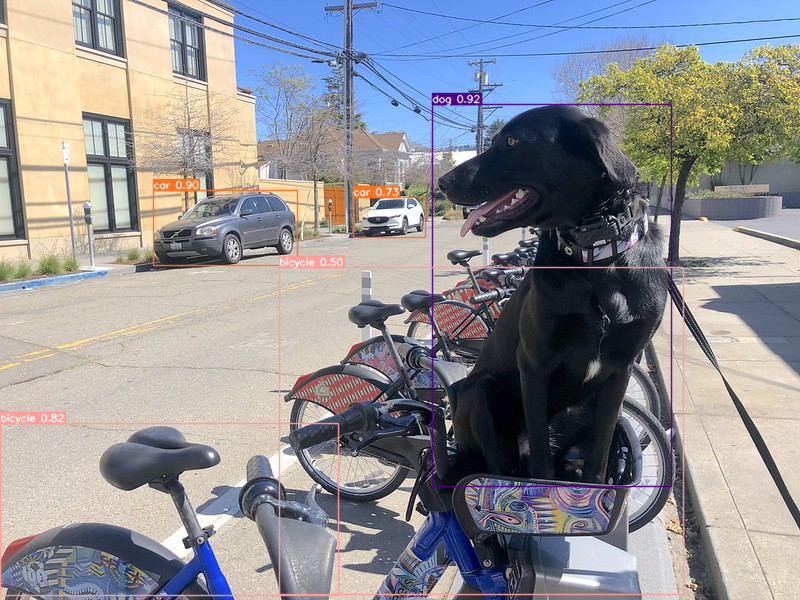

In [ ]:
def detect_without_preprocess(image: np.ndarray, model: ov.Model):
    """
    OpenVINO YOLOv8 model with integrated preprocessing inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    output_layer = model.output(0)
    img = letterbox(image)[0]
    input_tensor = np.expand_dims(img, 0)
    input_hw = img.shape[:2]
    result = model(input_tensor)[output_layer]
    detections = postprocess(result, input_hw, image)
    return detections


compiled_model = core.compile_model(quantized_model_with_preprocess, device.value)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect_without_preprocess(input_image, compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

## Live demo
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

In [ ]:
import collections
import time
from IPython import display

det_ov_model


# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_model,
    device=device.value,
):
    player = None
    ov_config = {}
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)

    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0])

    det_model.predictor.inference = infer

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            detections = det_model(input_image, verbose=False)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Object Detection
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try live inference on your webcam set `WEBCAM_INFERENCE = True`

Run the object detection:

In [ ]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4"

In [ ]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

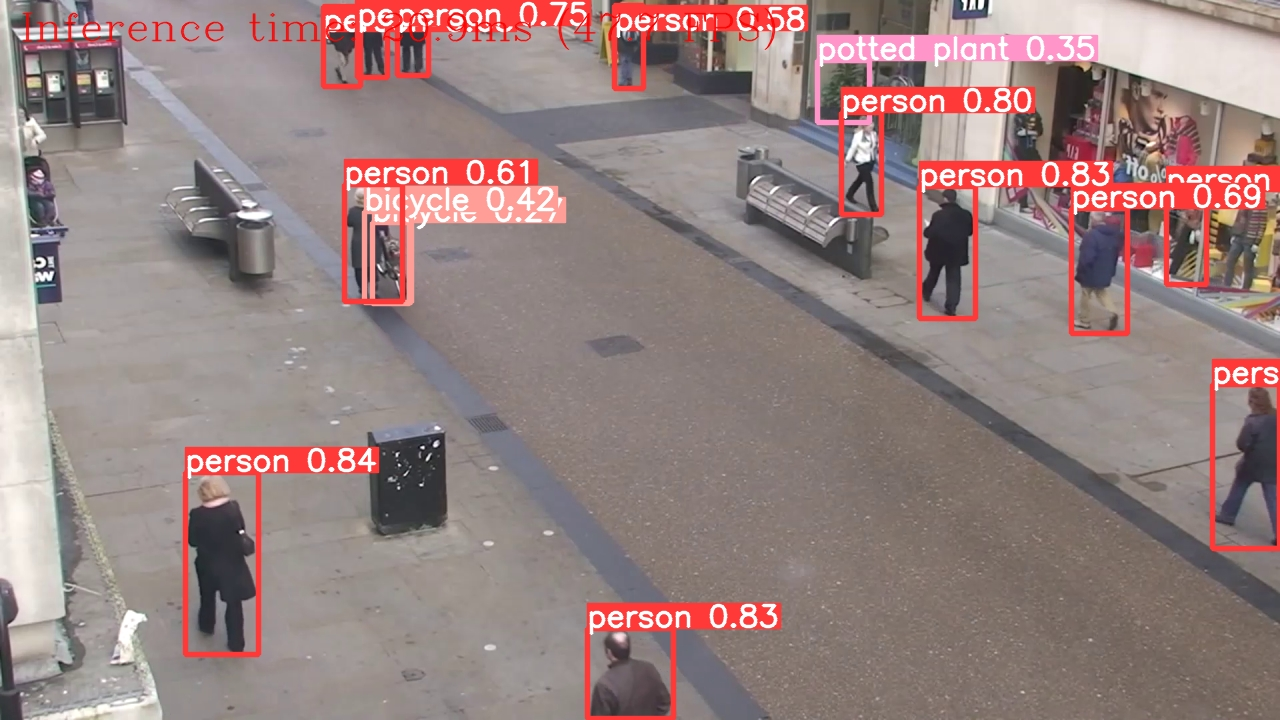

Source ended


In [ ]:
run_object_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=det_ov_model,
    device=device.value,
)

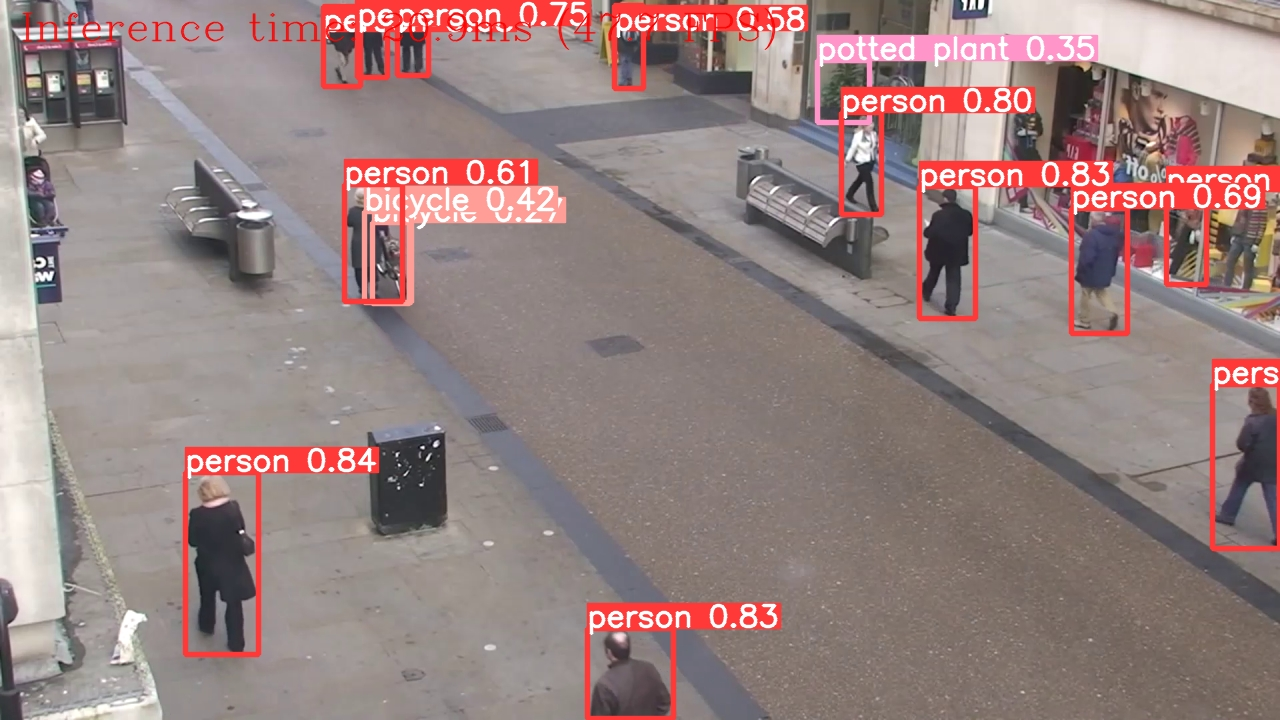

Source ended


In [ ]:
run_object_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=det_ov_model,
    device=device.value,
)

In [ ]:
import numpy as np
from openvino.runtime import Core
from PIL import Image

# Load OpenVINO model
ie = Core()
model_path = "models\yolov8n_openvino_model\yolov8n.xml"  # Your OpenVINO model path
model = ie.read_model(model=model_path)
compiled_model = ie.compile_model(model=model, device_name="AUTO")

# Image path
image_path = "data/construction_1.jpg"
image = Image.open(image_path)

# Preprocess the image
image = image.resize((640, 640))  # Resize to 640x640
image = np.array(image)  # Convert to numpy array
image = image.transpose((2, 0, 1))  # Change to (C, H, W)
image = np.expand_dims(image, axis=0)  # Add batch dimension -> (1, C, H, W)
image = image.astype(np.float32)  # Convert to float32

# Run inference
results = compiled_model([image])

# Post-process the results (e.g., drawing bounding boxes)
result_img = Image.fromarray(results[0].plot()[:, :, ::-1])  # Convert back to RGB format
result_img.show()


AttributeError: 'numpy.ndarray' object has no attribute 'plot'